# Prévisions météorologiques en Australie

# Modélisation avec étape de ré-échantillonage

# Récupération des librairies

In [1]:
# récupération du package imblearn
!pip install --upgrade imblearn

In [2]:
# récupération des librairies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import time, datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler

# Modèle de classification par apprentissage supervisé

In [3]:
# récuperation et aperçu du jeu de données après prétraitement des données, après l'étape de classification des villes 
# en fonction du climat et après sélection des variables les plus pertinentes selon la méthode SelectKBest()
df = pd.read_csv('../data/weatherAUS_preprocessed.csv', index_col=0)
df.head()

,Rainfall,Sunshine,WindGustSpeed,Humidity3pm,Pressure9am,Cloud3pm,Temp3pm,Temp_Delta_MinMax,Humidity_Delta,clim_chaud_humide,clim_méditerranéen,clim_sec,clim_tempéré_froid,RainTomorrow
0,0.6,4.94000,44.0,22.0,1007.7,7.40000,21.8,9.5,-49.0,1,0,0,0,0
1,0.0,7.63054,44.0,25.0,1010.6,4.49925,24.3,17.7,-19.0,1,0,0,0,0
2,0.0,7.96000,46.0,30.0,1007.6,2.00000,23.2,12.8,-8.0,1,0,0,0,0
3,0.0,7.63054,24.0,16.0,1017.6,4.49925,26.5,18.8,-29.0,1,0,0,0,0
4,1.0,0.90000,41.0,33.0,1010.8,8.00000,29.7,14.8,-49.0,1,0,0,0,0


In [4]:
# séparation des données en une matrice de données et en un vecteur cible
data = df.drop('RainTomorrow', axis=1)
target = df['RainTomorrow']

In [5]:
# division des données en un ensemble d'entraînement et un ensemble de test correspondant respectivement 
# à 80% et 20% de la quantité totale des données disponibles
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=123)

In [6]:
# undersampling des données
rUs = RandomUnderSampler()
X_train, y_train = rUs.fit_resample(X_train, y_train)

In [7]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
print("Cardinalité des classes de la variable cible ré-échantillonnée:", dict(pd.Series(y_train).value_counts()))

Cardinalité des classes de la variable cible ré-échantillonnée: {0: 25005, 1: 25005}


In [8]:
# distribution de la variable cible ré-échantillonnée dans l'ensemble d'entraînement
y_train.value_counts(normalize=True)

0    0.5
1    0.5
Name: RainTomorrow, dtype: float64

In [9]:
# distribution de la variable cible dans l'ensemble de test
print("Cardinalité des classes de la variable cible dans l'ensemble de test:", 
      dict(pd.Series(y_test).value_counts()))

Cardinalité des classes de la variable cible dans l'ensemble de test: {0: 21962, 1: 6196}


In [10]:
# distribution de la variable cible dans l'ensemble de test
y_test.value_counts(normalize=True)

0    0.779956
1    0.220044
Name: RainTomorrow, dtype: float64

In [11]:
# standardisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# paramètre à initialiser pour définir la règle d'évaluation des modèles
scoring = 'accuracy' # considéré dans le cadre de cette étude
# scoring = 'f1'

### Forêts Aléatoires

In [13]:
# définition du modèle
clf_rf  = RandomForestClassifier(class_weight={0:2, 1:1})

param_grid_rf  = [{'n_estimators' : [50, 100, 150], 
                   'min_samples_leaf' : np.arange(1,6,1),
                   'max_features' : ['sqrt', 'log2']}]

gcv_rf = GridSearchCV(clf_rf, param_grid_rf, scoring=scoring)

In [14]:
start_time = time.time()

# entraînement du modèle
gcv_rf.fit(X_train_scaled, y_train)

# prédiction du modèle
y_pred = gcv_rf.predict(X_test_scaled)

# détermination des meilleurs paramètres
print('Meilleurs paramètres:', gcv_rf.best_params_,"\n")

# évaluation de la performance
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)),'\n')

# underfitting / overfitting
print('Train Data Score: {}'.format(gcv_rf.score(X_train_scaled, y_train)))
print('Test Data Score: {}'.format(gcv_rf.score(X_test_scaled, y_test)))

# matrice de confusion
print('\n Matrice de confusion:')
print('\n', pd.crosstab(y_test, y_pred, rownames=['Réalités'], colnames=['Prédictions']))

# rapport de classification
print('\n', classification_report(y_test, y_pred))

# durée d'exécution
gaussian_time = (time.time() - start_time)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Meilleurs paramètres: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150} 

Accuracy Score: 0.7900063924994672 

Train Data Score: 1.0
Test Data Score: 0.7900063924994672

 Matrice de confusion:

 Prédictions      0     1
Réalités                
0            17303  4659
1             1254  4942

               precision    recall  f1-score   support

           0       0.93      0.79      0.85     21962
           1       0.51      0.80      0.63      6196

    accuracy                           0.79     28158
   macro avg       0.72      0.79      0.74     28158
weighted avg       0.84      0.79      0.80     28158

Running Time: 0:10:10.839166


- la méthode de forêt aléatoire **fait l'objet de sur-apprentissage** (score par défaut de la méthode).
- la sensibilité (taux de vrais positifs) vaut 0.80.
- la spécificité (taux de vrais négatifs) vaut 0.79.
- le F1-score concernant la classe '0' de la variable 'RainTomorrow' est très bon (0.85).
- le F1-score concernant la classe '1' de la variable 'RainTomorrow' est très faible (0.63).

La classe '1' est caractérisée par une précision très faible, ce qui signifie que la classe n'est quasiment pas détectée, et un rappel élevé, ce qui signifie que la classe inclut peu d'observations d'autres classes lorsqu'elle est détectée.

### Interprétation du modèle

L'interprétabilité du modèle Random Forest se situe quelque part entre un "whitebox" (comme un simple arbre de decision) et un vrai "blackbox" (comme un neural network).

A partir du meilleur estimateur trouvé précédemment, nous analysons d'abord les résultats du modèle par l'importance des variables en considérant la diminution moyenne de l'impureté pour tous les arbres de notre forêt.

In [15]:
# importance des variables dans le jeu de données d'entraînement
clf_rf = gcv_rf.best_estimator_

feats = {}
for feature, importance in zip(df.columns, clf_rf.feature_importances_):
    feats[feature] = importance
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Importance'})
importances.sort_values(by='Importance', ascending=False).head(8)

,Importance
Humidity3pm,0.188922
Temp_Delta_MinMax,0.128575
Pressure9am,0.117372
Sunshine,0.107915
Humidity_Delta,0.097777
Temp3pm,0.096913
WindGustSpeed,0.091884
Rainfall,0.069384


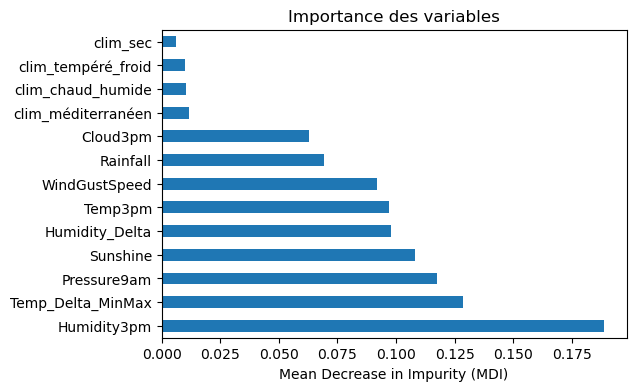

In [16]:
# affichage de l'importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
feature_imp = pd.Series(clf_rf.feature_importances_, index=data.columns)
feature_imp.nlargest(13).plot(kind='barh')
plt.title("Importance des variables")
plt.xlabel("Diminution Moyenne de l'Impureté (MDI)");

Comme nous l'avons vu pour les autres modèles, il apparaît clairement que la variable **"Humidity3pm"** est la plus importante dans ce modèle pour ce jeu de données.

Toutefois, deux problèmes subsistent avec les méthodes MDI pour déterminer l'importance des variables pour un jeu de données:

- la méthode est dépendante du modèle donc si le modèle est sujet au sur-apprentissage alors il peut y avoir un effet répercuté dans l'importance des variables également
- un biais de calcul peut survenir pour les variables numériques ou pour les variables présentant une grande cardinalité

Une autre technique d'inspection des modèles ne présente pas ces problèmes, il s'agit de la méthode de permutation importance qui se calcule sur le jeu de données de test. La fonction permutation_importance calcule l'importance des caractéristiques des estimateurs pour un jeu de données donné. Le paramètre *n_repeats* définit le nombre de fois qu'une entité est mélangée de manière aléatoire et renvoie un échantillon d'importance des caractéristiques. 

Cette méthode est légèrement plus coûteuse en temps de calcul que la méthode d'importance des variables.

In [17]:
# calcul de la permutation importance des estimateurs pour le jeu de données de test
result = permutation_importance(clf_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)

In [18]:
# création de l'index relatif aux estimateurs triés par importance moyenne 
sorted_idx = np.flip(result.importances_mean.argsort())

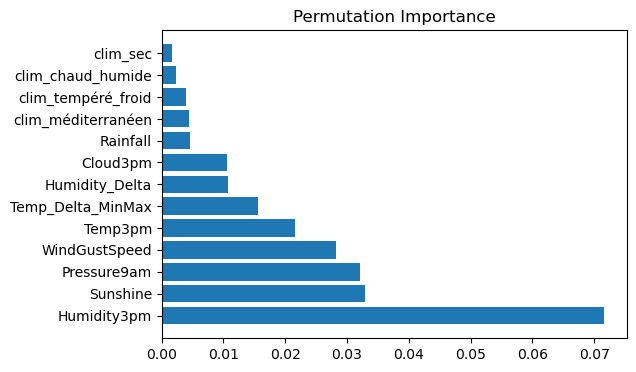

In [19]:
# affichage de la permutation importance des variables dans le jeu de données
fig = plt.figure(figsize=(6,4))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

Avec cette méthode, on s'aperçoit que la variable "Sunshine" est passée de la 4ème à la seconde position, devenant ainsi la variable la plus importante derrière "Humidity3pm". En revanche, la variable "Temp_Delta_MinMax" passe de la seconde à la 6ème position.